# Prostate Cancer Analysis
Data from Stamey et al. (1989), observing Radical Prostatectomy Treated Patients.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Import Dataset

In [2]:
df = pd.read_csv('prostate.data', sep='\t')
df = df.drop(df.columns[0], axis = 1)
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


Columns 1-8 are predictors: log cancer volume (lcavol), log prostate
weight (lweight), age, log of the amount of benign prostatic hyperplasia
(lbph), seminal vesicle invasion (svi), log of capsular penetration (lcp),
Gleason score (gleason), and percent of Gleason scores 4 or 5 (pgg45).

Column 9 is the outcome: log prostate specific antigen (lpsa).

I ignored Column 10 in this analysis.

In [3]:
df.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


### Scatterplots of the log of PSA against each of the eight clinical measures

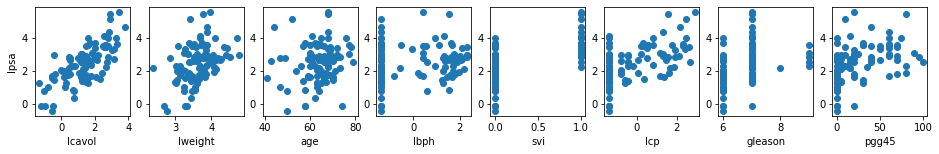

In [4]:
plt.figure(figsize = (16,2))
plt.subplot(181)
plt.xlabel('lcavol')
plt.ylabel('lpsa')
plt.scatter(y=df['lpsa'], x=df['lcavol'])

plt.subplot(182)
plt.xlabel('lweight')
plt.scatter(y= df["lpsa"], x=df['lweight'])

plt.subplot(183)
plt.xlabel('age')
plt.scatter(y= df["lpsa"], x=df['age'])

plt.subplot(184)
plt.xlabel('lbph')
plt.scatter(y= df["lpsa"], x=df['lbph'])

plt.subplot(185)
plt.xlabel('svi')
plt.scatter(y= df["lpsa"], x=df['svi'])

plt.subplot(186)
plt.xlabel('lcp')
plt.scatter(y= df["lpsa"], x=df['lcp'])

plt.subplot(187)
plt.xlabel('gleason')
plt.scatter(y= df["lpsa"], x=df['gleason'])

plt.subplot(188)
plt.xlabel('pgg45')
plt.scatter(y= df["lpsa"], x=df['pgg45'])

### Split into training and testing data

In [5]:
# attributes stored in X.
X = df[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']]

# outcome stored in y
y = df['lpsa']

# Randomly choose a training set of size 67 and a test size of 30
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Fit a linear model and calculate error

In [6]:
# normalize the predictors to each have unit variance
sd = X_train.std(axis=0)
X_train_norm = X_train/sd
X_train_norm.std(axis=0)   # sd of each regressor is 1
X_train_norm.mean(axis=0)  # mean has not been changed

# fit the model using multivariate linear regression
reg_norm = LinearRegression().fit(X_train_norm, y_train)
reg_norm.coef_

# resulting estimates for the coefficients
coeff_norm = pd.DataFrame([df.columns[0:8], reg_norm.coef_])  
coeff_norm

,0,1,2,3,4,5,6,7
0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,0.711016,0.337305,-0.215884,0.156272,0.253684,-0.180005,0.1096,0.14292


In [7]:
# predict on test data
y_pred_norm = reg_norm.predict(X_test)

# check difference between actual and predicted for L2 error (sum of squared)
squared_errors_norm = (y_pred_norm - y_test) ** 2
sse_norm =  np.sum(squared_errors_norm)
sse_norm

3382.340914842198

In [8]:
# linear model score on training
reg_norm.score(X_train_norm, y_train)

0.6865467477025375

In [9]:
# linear model score on testing
reg_norm.score(X_test, y_test)

-100.56102798038377

### Fit L2-regularized linear model

In [10]:
# ridge regression via ten-fold cross-validation
ridgeReg = Ridge()
alphas = np.linspace(1e-12, 100 , 5)
tunedParameters = {'alpha':alphas}
cvEstimator = GridSearchCV(ridgeReg, tunedParameters, cv=10, refit=True)
cvEstimator.fit(X_train_norm,y_train)
ridgeBest = cvEstimator.best_estimator_
alphaBest = cvEstimator.best_params_['alpha']

In [11]:
# ridge CV L2 error
y_pred_cv = ridgeBest.predict(X_test)

squared_errors = (y_pred_cv - y_test) ** 2
sse_cv =  np.sum(squared_errors)
sse_cv

254.39711531423927

In [12]:
# ridge CV score on training
ridgeBest.score(X_train_norm, y_train)

0.6016502191863636

In [13]:
# ridge CV score on test
ridgeBest.score(X_test, y_test)

-6.638742869822092

In [14]:
# choose parameters for ridge regression via AIC

from math import log
n = len(X_train_norm)

alphas = np.linspace(1e-12, 0.2 , 50)
min_val = 1000
min_alpha = 0
for i in alphas:
    ridge = Ridge(alpha = i)
    ridge.fit(X_train_norm, y_train)
    ridge.get_params()
    
    # Find SSE
    y_pred_AIC = ridge.fit(X_train_norm, y_train).predict(X_test)
    sse_AIC = np.sum((y_pred_AIC - y_test) **2)
    
    
    S = (X_train_norm.dot(np.linalg.inv((X_train_norm.transpose().dot(X_train_norm) + i * np.identity(len(X_train_norm.columns)))))).values.dot(X_train_norm.transpose())
    degf = S.trace()

    AIC = ((2/n) * degf) + log(sse_AIC / (n - degf))
    
    if (AIC < min_val):
        min_val = AIC
        min_alpha = i

ridge = Ridge(alpha = min_alpha)
regrAic = ridge.fit(X_train_norm, y_train)

In [15]:
# ridge AIC score on training
regrAic.score(X_train_norm, y_train)

0.6865350214394128

In [16]:
# ridge AIC score on testing
regrAic.score(X_test, y_test)

-98.67967583244437

In [17]:
# coefficient estimates using ridge regression via cross-validation
pd.DataFrame([df.columns[0:8], ridgeBest.coef_])  

,0,1,2,3,4,5,6,7
0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,0.348993,0.220641,-0.0438749,0.0979874,0.173109,0.0945364,0.0812774,0.0840123


In [18]:
# coefficient estimates using ridge regression via information criteria
pd.DataFrame([df.columns[0:8], regrAic.coef_])  

,0,1,2,3,4,5,6,7
0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,0.706756,0.336579,-0.213497,0.15596,0.252242,-0.17407,0.108886,0.141096


### Fit L1-regularized linear model

In [19]:
# fit the model with LASSO by cross-validation
from sklearn.linear_model import Lasso

regLasso = Lasso()
alphas = np.linspace(1e-12, 50, 50)
tunedParameters = {'alpha':alphas}
cvEstimator = GridSearchCV(regLasso, tunedParameters, cv=10, refit=True)
cvEstimator.fit(X_train_norm, y_train)
lassoBest = cvEstimator.best_estimator_
alphaBest = cvEstimator.best_params_['alpha']

In [20]:
# fit the model with LASSO by AIC Information Criterion
from sklearn.linear_model import LassoLarsIC
lasso_aic = LassoLarsIC(criterion='aic')
lassoAic = lasso_aic.fit(X_train, y_train)

In [21]:
# coefficient estimates using LASSON via cross-validation
pd.DataFrame([df.columns[0:8], lassoBest.coef_])  

,0,1,2,3,4,5,6,7
0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,0.711016,0.337305,-0.215884,0.156272,0.253684,-0.180005,0.1096,0.14292


In [22]:
# LASSO CV score on training
lassoBest.score(X_train_norm,y_train)

0.6865467477025375

In [23]:
# LASSO CV score on testing
lassoBest.score(X_test,y_test)

-100.56102797761805

In [24]:
# coefficient estimates using LASSO via information criteria
pd.DataFrame([df.columns[0:8], lassoAic.coef_]) 

,0,1,2,3,4,5,6,7
0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,0.530066,0.476641,0,0,0.246502,0,0,0


In [25]:
# LASSO AIC score on training
lassoAic.score(X_train_norm, y_train)

-2.5324141247074365

In [26]:
# LASSO AIC score on testing
lassoAic.score(X_test, y_test)

0.5969666816898411

With LASSO, some attributes were sent to 0, which means they are not significant to the model (variable selection).

The sign of each regression coefficient tells you whether there is a positive or negative correlation between the respective independent and  dependent variable. The most significant regressors for the outcome variable, lpsa, are lcavol (positive correlation), lweight (positive correlation), age (negative correlation), svi (postiive correlation), and gleason (positive correlation).